In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/sophie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sophie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sophie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sophie/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

In [4]:
import os
dir_path = '/Users/sophie/Desktop'

# List files in the directory
files = os.listdir(dir_path)

# Assuming your data file is a CSV file named 'IMDB Dataset.csv'
data = pd.read_csv(os.path.join(dir_path, 'IMDB_Dataset.csv'))


Class Distribution:
 positive    25000
negative    25000
Name: sentiment, dtype: int64


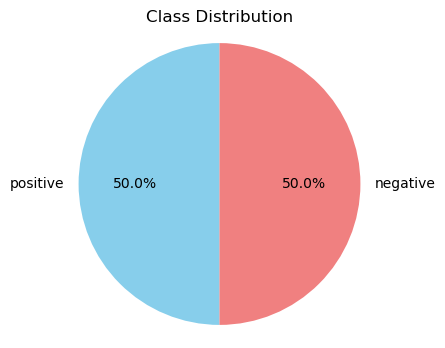

In [5]:
# Descriptive statistics (class distribution)
class_distribution = data['sentiment'].value_counts()
print("\nClass Distribution:\n", class_distribution)

plt.figure(figsize=(4, 4))
class_distribution.plot.pie(autopct='%1.1f%%', startangle=90, colors= ['skyblue', 'lightcoral'])
plt.title('Class Distribution')
plt.ylabel('')
plt.axis('equal')
plt.show()

# Data Preprocessing

In [6]:
def preprocess(text):
    # Clean text
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase

    # Tokenize
    words = word_tokenize(text)

    # Remove stopwords, personal pronouns, determiners, coordinating conjunctions, and prepositions
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words and word.lower() not in ["he", "she", "i", "we", "the", "a", "an", "another", "for", "and", "nor", "but", "or", "yet", "so", "in", "under", "towards", "before"]]

    # From adv to adj
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, pos='a') for word in words]

    # Join words back into sentence
    processed_text = ' '.join(words)

    return processed_text


In [7]:
data['processed_reviews'] = data['review'].apply(preprocess)
data.head()

,review,sentiment,processed_reviews
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


## Word Cloud

In [8]:
# Function to extract adj from text
def extract_adjectives(text):
    tokens = word_tokenize(text)
    tagged_words = pos_tag(tokens)
    adjectives = [word.lower() for word, tag in tagged_words if tag.startswith('JJ')]
    return ' '.join(adjectives)

data['adjective_reviews'] = data['processed_reviews'].apply(extract_adjectives)

# Combine all adj into a string
adjective_text = ' '.join(data['adjective_reviews'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(adjective_text)

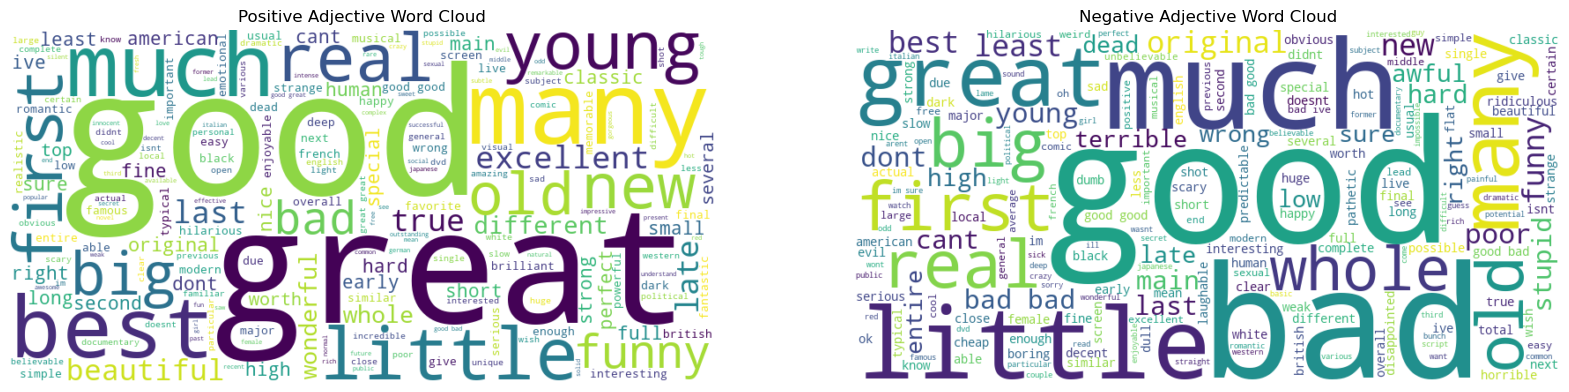

In [9]:
positive_reviews = data[data['sentiment'] == 'positive']['adjective_reviews']
negative_reviews = data[data['sentiment'] == 'negative']['adjective_reviews']

# Combine all adj for each sentiment
positive_adjective_text = ' '.join(positive_reviews)
negative_adjective_text = ' '.join(negative_reviews)

# Word Cloud for positive adj
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_adjective_text)

# Word Cloud for negative adj
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_adjective_text)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Adjective Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Adjective Word Cloud')
plt.axis('off')

plt.show()

# Sentiment Analysis

In [10]:
with open('/Users/sophie/Desktop/positive_words.txt', 'r') as file:
    positive_text = file.read()
with open('/Users/sophie/Desktop/negative_words.txt', 'r') as file:
    negative_text = file.read()

sentiment_dict = list(set(word_tokenize(positive_text) + word_tokenize(negative_text)))
print(len(sentiment_dict))

6790


In [11]:
def filter_words(word_list, training_data):
    # Tokenize training data & create unique words set
    unique_words_set = set(word for text in training_data for word in word_tokenize(text))

    # Filter list based on the unique words
    filtered_words = [word for word in word_list if word in unique_words_set]

    return filtered_words

filtered_word_list = filter_words(sentiment_dict, data['processed_reviews'])
print(len(filtered_word_list))

5739


In [12]:
def encode_and_select_features(text_vector, word_list, target_variable, num_features_to_select):
    
    tokenized_text = [word_tokenize(text) for text in text_vector]
    tfidf_vectorizer = TfidfVectorizer(vocabulary=word_list)
    tfidf_matrix = tfidf_vectorizer.fit_transform([" ".join(tokens) for tokens in tokenized_text])

    # Selecting K best features using chi-squared test
    selector = SelectKBest(score_func=chi2, k=num_features_to_select)
    selected_features = selector.fit_transform(tfidf_matrix, target_variable)

    return selected_features

num_features_to_select = 300
selected_features = encode_and_select_features(data['processed_reviews'], filtered_word_list, data['sentiment'],
                                               num_features_to_select)
reduced_matrix= selected_features.toarray()

In [13]:
print(reduced_matrix.shape)
print(reduced_matrix)

(50000, 300)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Model Training

In [14]:
X = reduced_matrix
y = data['sentiment'].map({'positive': 1, 'negative': 0}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [15]:
# Function for plotting ROC curves
def plot_roc_curve(fpr, tpr, model_name, auc_score):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (auc = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='best')
    plt.show()

Logistic Regression Accuracy: 0.84176
              precision    recall  f1-score   support

           0     0.8596    0.8165    0.8375     12483
           1     0.8257    0.8670    0.8458     12517

    accuracy                         0.8418     25000
   macro avg     0.8426    0.8417    0.8416     25000
weighted avg     0.8426    0.8418    0.8417     25000



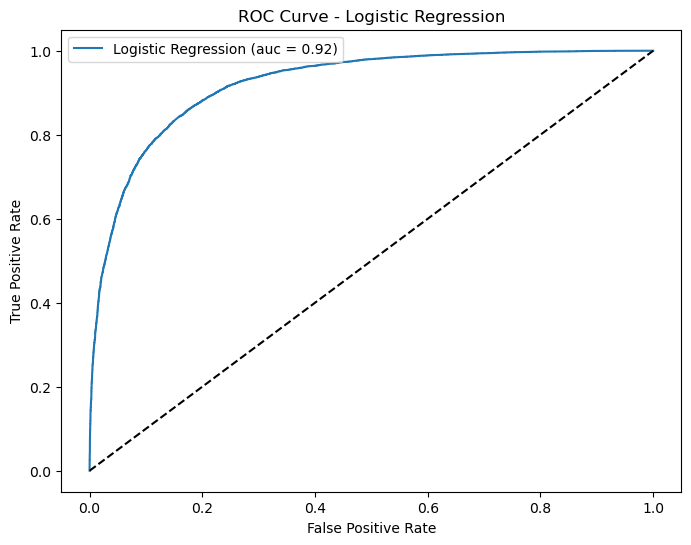

In [16]:
# Logistic Regression
model = LogisticRegression(max_iter=1000)
name = 'Logistic Regression'
model.fit(X_train, y_train)

predictions = model.predict(X_test)
test_accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions, digits=4)
print(f"{name} Accuracy: {test_accuracy}")
print(report)

# ROC Curve
proba_predictions = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, proba_predictions)
auc_score = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, name, auc_score)


Best Parameters:  {'n_neighbors': 25}
KNN Accuracy: 0.7722
Classification Report:
               precision    recall  f1-score   support

           0     0.8470    0.6636    0.7442     12483
           1     0.7241    0.8805    0.7947     12517

    accuracy                         0.7722     25000
   macro avg     0.7856    0.7721    0.7694     25000
weighted avg     0.7855    0.7722    0.7695     25000



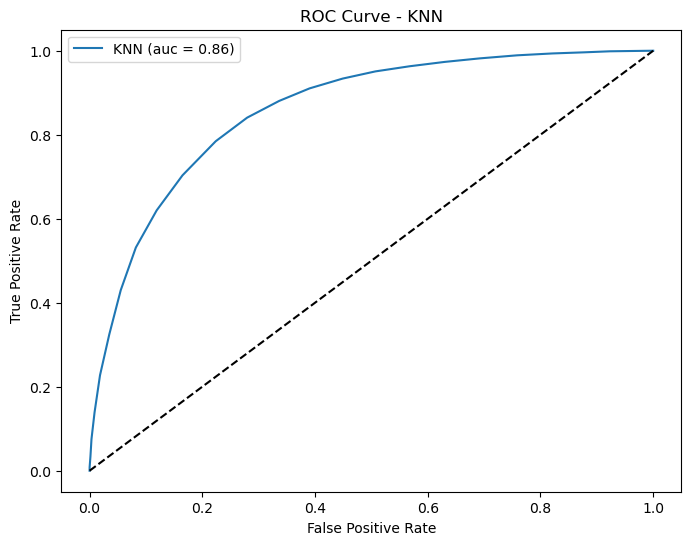

In [17]:
# KNN
name = 'KNN'
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [1, 5, 13, 17, 25, 77,93]}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
test_accuracy = grid_search.score(X_test, y_test)
predictions = grid_search.predict(X_test)
report = classification_report(y_test, predictions, digits=4)
print("Best Parameters: ", grid_search.best_params_)
print(f"{name} Accuracy: {test_accuracy}")
print("Classification Report:\n", report)

# KNN ROC Curve
proba_predictions = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, proba_predictions)
auc_score = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, name, auc_score)

Best Parameters:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Decision Tree Accuracy: 0.7322
Classification Report:
               precision    recall  f1-score   support

           0     0.7326    0.7303    0.7314     12483
           1     0.7318    0.7341    0.7330     12517

    accuracy                         0.7322     25000
   macro avg     0.7322    0.7322    0.7322     25000
weighted avg     0.7322    0.7322    0.7322     25000



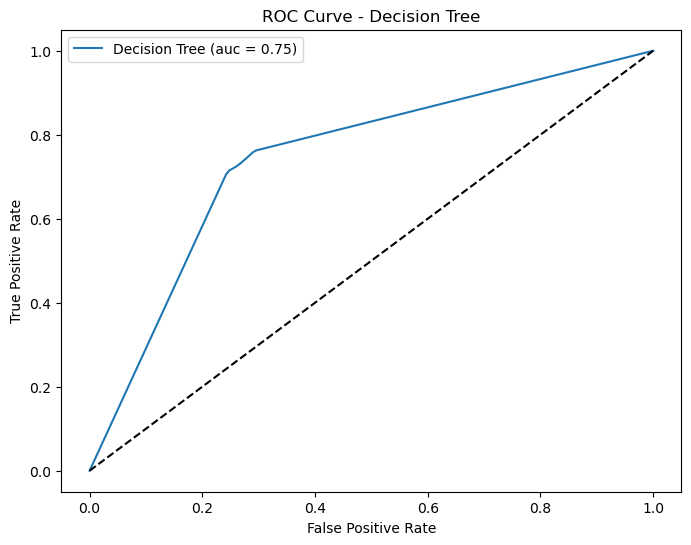

In [18]:
# Decision Tree
name = "Decision Tree"
dt_classifier = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 4, 8],
    'min_samples_split': [1, 2, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
test_accuracy = grid_search.score(X_test, y_test)
predictions = grid_search.predict(X_test)
report = classification_report(y_test, predictions, digits=4)
print("Best Parameters: ", grid_search.best_params_)
print(f"{name} Accuracy: {test_accuracy}")
print("Classification Report:\n", report)

# DT ROC Curve
proba_predictions = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, proba_predictions)
auc_score = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, name, auc_score)

Best Parameters:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest Accuracy: 0.8052
Classification Report:
               precision    recall  f1-score   support

           0     0.8378    0.7562    0.7949     12483
           1     0.7784    0.8540    0.8145     12517

    accuracy                         0.8052     25000
   macro avg     0.8081    0.8051    0.8047     25000
weighted avg     0.8081    0.8052    0.8047     25000



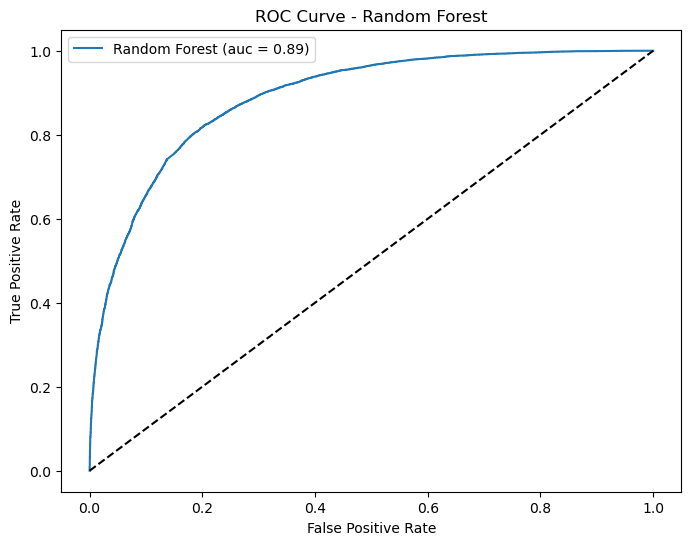

In [19]:
# Random Forest
name = 'Random Forest'
rf_classifier = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 30],
    'min_samples_split': [1, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
test_accuracy = grid_search.score(X_test, y_test)
predictions = grid_search.predict(X_test)
report = classification_report(y_test, predictions, digits=4)
print("Best Parameters: ", grid_search.best_params_)
print(f"{name} Accuracy: {test_accuracy}")
print("Classification Report:\n", report)

# RF ROC Curve
proba_predictions = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, proba_predictions)
auc_score = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, name, auc_score)

In [20]:
# LDA: check the assumption on same covariance
classes = np.unique(y)
cov_matrices = []

# Calculate the covariance matrix for each class
for class_val in classes:
    class_data = X[y == class_val]

    if class_data.ndim == 2:
        cov_matrix = np.cov(class_data.T)
        cov_matrices.append(cov_matrix)
        print(f"Covariance Matrix for Class {class_val}:\n{cov_matrix}\n")

# Compare the covariance matrices
n_classes = len(cov_matrices)
for i in range(n_classes):
    for j in range(i+1, n_classes):
        diff = cov_matrices[i] - cov_matrices[j]
        frob_norm = np.linalg.norm(diff, 'fro')  # Frobenius norm
        print(f"Difference between covariance matrices of class {i} and class {j}: {frob_norm}")


Covariance Matrix for Class 0:
[[ 8.61339225e-04 -6.21848812e-06 -6.34717621e-06 ... -2.76019919e-07
  -2.56081705e-06 -1.91198341e-06]
 [-6.21848812e-06  2.26591660e-03  2.06712811e-06 ... -8.47139202e-07
  -1.02390895e-05 -2.72668855e-06]
 [-6.34717621e-06  2.06712811e-06  6.64205204e-04 ... -1.99296757e-07
  -5.32311016e-07  1.53523284e-06]
 ...
 [-2.76019919e-07 -8.47139202e-07 -1.99296757e-07 ...  2.83873937e-05
  -3.85355297e-07 -5.67420810e-08]
 [-2.56081705e-06 -1.02390895e-05 -5.32311016e-07 ... -3.85355297e-07
   1.22116221e-03 -2.66934697e-06]
 [-1.91198341e-06 -2.72668855e-06  1.53523284e-06 ... -5.67420810e-08
  -2.66934697e-06  1.72365881e-04]]

Covariance Matrix for Class 1:
[[ 2.91058163e-04 -2.69031252e-07 -4.18955929e-07 ...  1.47363506e-06
  -2.16412935e-06 -2.26775884e-07]
 [-2.69031252e-07  1.36752467e-03 -1.60858126e-06 ...  3.01736768e-06
  -6.45195991e-06 -1.53159834e-06]
 [-4.18955929e-07 -1.60858126e-06  1.16473262e-04 ... -3.29079147e-07
  -3.43772864e-07  2.

LDA Accuracy: 0.83924
              precision    recall  f1-score   support

           0     0.8635    0.8053    0.8334     12483
           1     0.8181    0.8731    0.8447     12517

    accuracy                         0.8392     25000
   macro avg     0.8408    0.8392    0.8390     25000
weighted avg     0.8408    0.8392    0.8391     25000



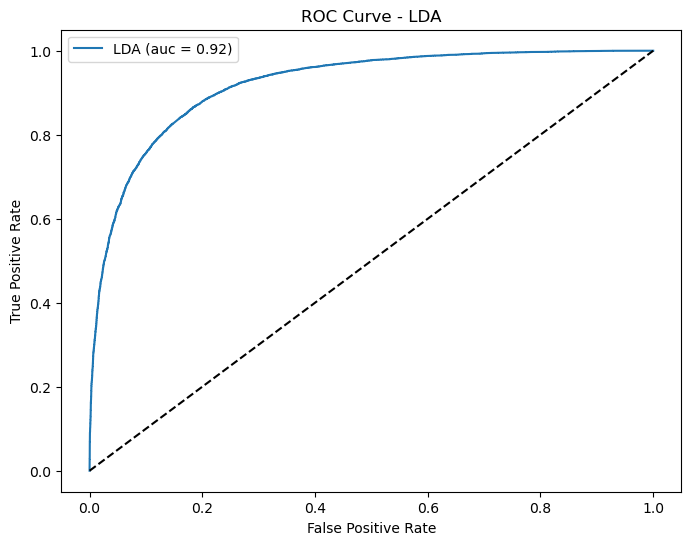

In [21]:
# LDA
model = LinearDiscriminantAnalysis()
name = 'LDA'
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions, digits=4)
print(f"{name} Accuracy: {accuracy}")
print(report)

# ROC Curve
proba_predictions = model.predict_proba(X_test)[:, 1]  # Probabilities needed for ROC curve
fpr, tpr, _ = roc_curve(y_test, proba_predictions)
auc_score = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, name, auc_score)

QDA Accuracy: 0.79008
              precision    recall  f1-score   support

           0     0.8393    0.7168    0.7732     12483
           1     0.7535    0.8631    0.8046     12517

    accuracy                         0.7901     25000
   macro avg     0.7964    0.7900    0.7889     25000
weighted avg     0.7963    0.7901    0.7889     25000



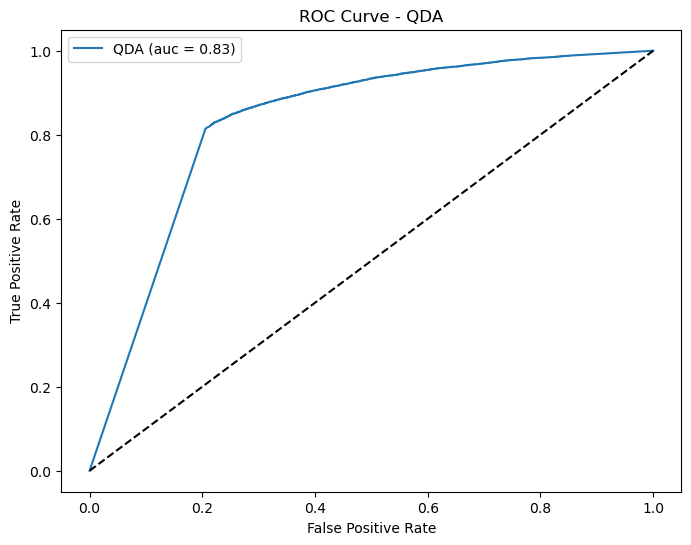

In [22]:
# QDA
model = QuadraticDiscriminantAnalysis()
name = 'QDA'
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions, digits=4)
print(f"{name} Accuracy: {accuracy}")
print(report)

# ROC Curve
proba_predictions = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, proba_predictions)
auc_score = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, name, auc_score)